In [18]:
source('run_2_stage_util.R')
require(tidyverse)
require(rstan)
require(ggplot2)
require(mvtnorm)

In [19]:
sim_params = readRDS('simulation_params.RDS')

In [20]:
names(sim_params)

[1] "died"                 "sigma_0"              "mu_0"                
 [4] "sigma_1"              "mu_1"                 "missing_rate"        
 [7] "missing_rate_numeric" "mu_missing"           "sigma_2_missing"     
[10] "metabolites"

In [21]:
died = sim_params$died
sigma_0 = sim_params$sigma_0
mu_0 = sim_params$mu_0
sigma_1 = sim_params$sigma_1
mu_1 = sim_params$mu_1
mu_missing = sim_params$mu_missing
sigma_2_missing = sim_params$sigma_2_missing
metabolites = sim_params$metabolites
missing_rate = sim_params$missing_rate
missing_rate_numeric = sim_params$missing_rate_numeric

### LOAD THE MODEL
* This may need to compile and may take some time

In [22]:
rstan_options(auto_write = TRUE)
stage_1_impute_code_file = 'stage_1_impute.stan'
stage_1_impute_model = stan_model(file = stage_1_impute_code_file, verbose = FALSE)

stage_2_regress_code_file = 'stage_2_regress.stan'
stage_2_regress_model = stan_model(file = stage_2_regress_code_file, verbose = FALSE)


DIAGNOSTIC(S) FROM PARSER:
Info:
Left-hand side of sampling statement (~) may contain a non-linear transform of a parameter or local variable.
If it does, you need to include a target += statement with the log absolute determinant of the Jacobian of the transform.
Left-hand-side of sampling statement:
    x_impute ~ normal(...)



### SIMULATE DATA

In [23]:
missing_dist_params = get_alpha_beta_for_target_rate_2(missing_rate_numeric,TARGET_MISSING_RATE=0.2)

df_sim = make_df(n_0=100,mu_0,sigma_0,n_1=100,mu_1,sigma_1,frac_sig=0.5,censor=TRUE,max_missing=0.4,alpha=missing_dist_params$alpha,beta=missing_dist_params$beta)



#### Uncensored Data

In [24]:
df_sim$df_sample %>% head()

,hydroxybutyrate,oxoisocaproate,X3.hydoxybutyrate,alanine,betaine,carnitine,choline,citrate,creatine,creatinine,⋯,methionine,oacetylcarnitine,ornithine,phenylalanine,proline,propyleneglycol,pyruvate,tyrosine,valine,died_90_day
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.7450388,-0.4153899,-0.9302064,0.7102944,-0.2009855,2.0368940,-0.58559856,0.3711240,-1.6997257,-0.03191366,⋯,0.04343974,-0.94298002,1.1763412,0.3310704,1.47222967,0.59636417,-0.1259288,-0.64061193,-0.07743961,0
2,1.0061604,0.5506982,-0.3558473,2.0948634,0.5327135,1.2482921,0.34516543,-0.9442678,0.8652399,-0.05266257,⋯,2.47343629,0.09340784,2.0310227,1.6159140,1.00960523,0.59039439,-0.5555537,0.97091942,1.37258433,0
3,-0.6223027,-0.4065140,0.4443967,-0.1228642,0.2985912,0.3650053,1.82474036,0.2623764,-0.7297369,0.16087827,⋯,0.18884152,-0.49990981,-0.2965558,0.3074868,-0.09605885,0.26529687,-1.2861114,0.11326561,0.09088221,0
4,2.1575735,-1.6379405,0.2225454,1.7023689,0.4694929,-0.4605445,-0.02715504,1.8474971,2.0597010,-0.58000030,⋯,2.06491477,0.72195464,1.7215150,2.1919470,2.72017966,0.04860549,2.4303384,0.97207203,-0.38370798,0
5,-1.1289403,-0.5056871,-2.6590935,-0.5028471,-0.7651975,1.6022826,0.99518632,-0.8849502,0.7468966,1.32162063,⋯,-1.30187043,-0.71905784,-0.9665124,-0.3322134,-0.36099155,-1.65047818,-0.3695790,-0.09560781,-1.16697018,0
6,-0.1973063,0.1335065,0.8709358,-0.8734647,-0.2890047,-1.3042536,0.74919911,-0.1449903,-0.9643418,0.93195912,⋯,-1.65199902,-0.70988181,-1.7279688,-0.9551541,-0.11923896,-1.11891886,0.5957254,-1.62104327,-1.35509321,0


#### Censored Data

In [25]:
df_sim$df_censored %>% head()

,hydroxybutyrate,oxoisocaproate,X3.hydoxybutyrate,alanine,betaine,carnitine,choline,citrate,creatine,creatinine,⋯,methionine,oacetylcarnitine,ornithine,phenylalanine,proline,propyleneglycol,pyruvate,tyrosine,valine,died_90_day
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.7450388,NA,NA,0.7102944,-0.2009855,2.0368940,NA,0.3711240,NA,-0.03191366,⋯,0.04343974,NA,1.1763412,0.3310704,1.47222967,0.59636417,-0.1259288,NA,-0.07743961,0
2,1.0061604,0.5506982,-0.3558473,2.0948634,0.5327135,1.2482921,0.34516543,-0.9442678,0.8652399,-0.05266257,⋯,2.47343629,0.09340784,2.0310227,1.6159140,1.00960523,0.59039439,NA,0.97091942,1.37258433,0
3,-0.6223027,NA,0.4443967,-0.1228642,0.2985912,0.3650053,1.82474036,0.2623764,NA,0.16087827,⋯,0.18884152,NA,-0.2965558,0.3074868,-0.09605885,0.26529687,NA,0.11326561,0.09088221,0
4,2.1575735,NA,0.2225454,1.7023689,0.4694929,-0.4605445,-0.02715504,1.8474971,2.0597010,-0.58000030,⋯,2.06491477,0.72195464,1.7215150,2.1919470,2.72017966,0.04860549,2.4303384,0.97207203,-0.38370798,0
5,-1.1289403,NA,NA,-0.5028471,NA,1.6022826,0.99518632,-0.8849502,0.7468966,1.32162063,⋯,NA,NA,NA,-0.3322134,NA,NA,-0.3695790,-0.09560781,NA,0
6,-0.1973063,0.1335065,0.8709358,-0.8734647,-0.2890047,NA,0.74919911,-0.1449903,NA,0.93195912,⋯,NA,NA,NA,-0.9551541,-0.11923896,NA,0.5957254,NA,NA,0


#### Naive Imputation

In [26]:
df_sim$df_naive_impute %>% head()

,hydroxybutyrate,oxoisocaproate,X3.hydoxybutyrate,alanine,betaine,carnitine,choline,citrate,creatine,creatinine,⋯,methionine,oacetylcarnitine,ornithine,phenylalanine,proline,propyleneglycol,pyruvate,tyrosine,valine,died_90_day
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-0.7450388,-0.9720172,-1.4593155,0.7102944,-0.2009855,2.0368940,-1.12087026,0.3711240,-1.1748121,-0.03191366,⋯,0.04343974,-1.15438571,1.1763412,0.3310704,1.47222967,0.59636417,-0.1259288,-1.12638433,-0.07743961,0
2,1.0061604,0.5506982,-0.3558473,2.0948634,0.5327135,1.2482921,0.34516543,-0.9442678,0.8652399,-0.05266257,⋯,2.47343629,0.09340784,2.0310227,1.6159140,1.00960523,0.59039439,-1.0761777,0.97091942,1.37258433,0
3,-0.6223027,-0.9720172,0.4443967,-0.1228642,0.2985912,0.3650053,1.82474036,0.2623764,-1.1748121,0.16087827,⋯,0.18884152,-1.15438571,-0.2965558,0.3074868,-0.09605885,0.26529687,-1.0761777,0.11326561,0.09088221,0
4,2.1575735,-0.9720172,0.2225454,1.7023689,0.4694929,-0.4605445,-0.02715504,1.8474971,2.0597010,-0.58000030,⋯,2.06491477,0.72195464,1.7215150,2.1919470,2.72017966,0.04860549,2.4303384,0.97207203,-0.38370798,0
5,-1.1289403,-0.9720172,-1.4593155,-0.5028471,-1.3452896,1.6022826,0.99518632,-0.8849502,0.7468966,1.32162063,⋯,-0.80672121,-1.15438571,-1.4987812,-0.3322134,-0.89733605,-1.57649128,-0.3695790,-0.09560781,-1.56297271,0
6,-0.1973063,0.1335065,0.8709358,-0.8734647,-0.2890047,-1.3068333,0.74919911,-0.1449903,-1.1748121,0.93195912,⋯,-0.80672121,-1.15438571,-1.4987812,-0.9551541,-0.11923896,-1.57649128,0.5957254,-1.12638433,-1.56297271,0


#### Minimum Observed Values

In [27]:
df_sim$est.thresholds

[1] -1.1318045 -0.2788700 -0.7661683 -0.9760158 -0.6521424 -0.6136861
 [7] -0.4277231 -0.9809450 -0.4816649 -1.7007191 -0.9514407 -0.8678749
[13] -0.7443542 -0.3299261 -0.3803053 -0.2615792 -0.3908321 -0.9182785
[19] -0.1135740 -0.4612385 -0.8056340 -1.2178689 -0.2041889 -0.8833441
[25] -0.3830305 -0.4332371 -0.8698255

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



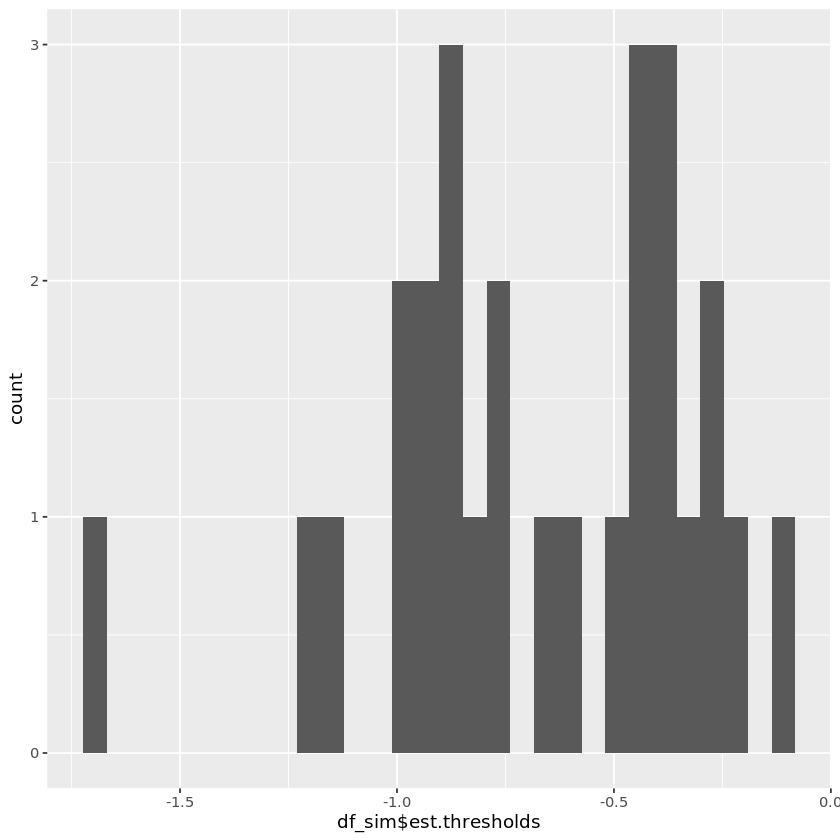

In [28]:
ggplot() + geom_histogram(aes(x=df_sim$est.thresholds))

In [33]:
mean( df_sim$missing_rates )

[1] 0.2505191

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



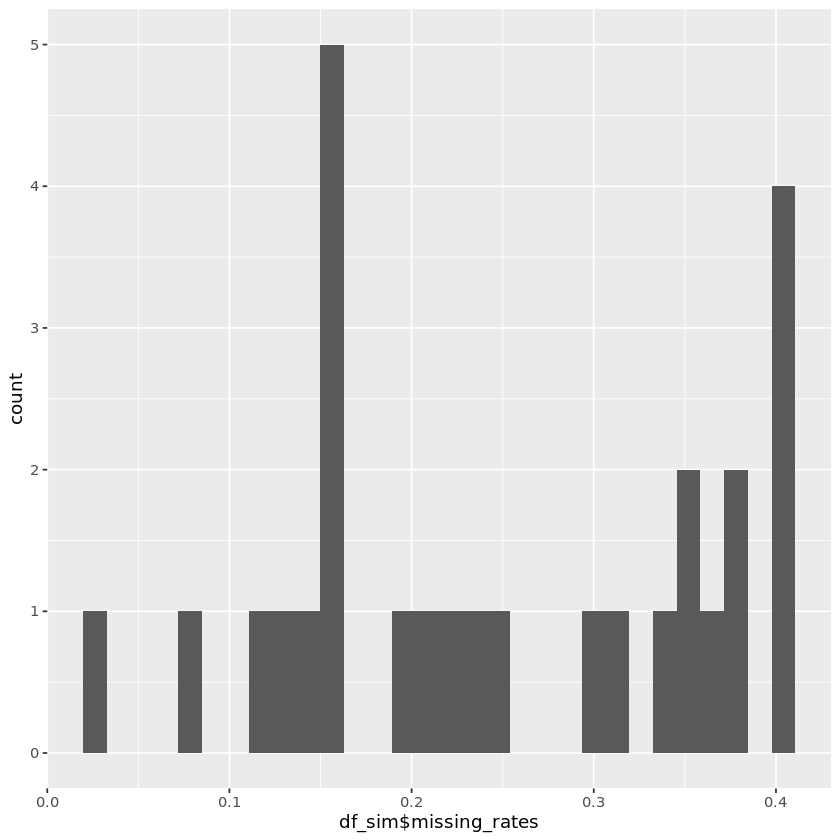

In [30]:
ggplot() + geom_histogram(aes(x=df_sim$missing_rates))

### FIT BAYES MODEL

In [31]:
bayes.res = run_bayes_model(df_sim$df_censored,metabolites,cores=4,chains=4,iter=2000, 
                           adapt_delta=0.8,
                           max_treedepth=10, y_column='died_90_day', sigma_beta_x_lower_bound=0)


[1] "CONTROL"
$adapt_delta
[1] 0.8

$max_treedepth
[1] 10

[1] "IMPUTING"
[1] 1360


In [34]:
sum_table = bayes.res$sum_table
stage_1_fit = bayes.res$stage_1_fit
stage_2_fit = bayes.res$stage_2_fit

In [35]:
sum_table

,Metabolite,Param,mean,sd,X2.5.,X50.,X97.5.,Rhat,Z,P_GT_LT_0
,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
propyleneglycol,propyleneglycol,beta_x[24],0.745042733,0.1753549,0.42172730,0.73816119,1.1058020,1.0004639,4.24877112,1.00000
betaine,betaine,beta_x[5],0.834282810,0.1995406,0.46460438,0.82483506,1.2519523,1.0009633,4.18101708,1.00000
lactate,lactate,beta_x[16],0.635575710,0.1781467,0.30859605,0.62839398,0.9988110,1.0001969,3.56771065,1.00000
oacetylcarnitine,oacetylcarnitine,beta_x[20],0.546425206,0.1606936,0.24304571,0.54021599,0.8766203,1.0001032,3.40041769,0.99975
lysine,lysine,beta_x[18],0.324171503,0.1464099,0.05468362,0.31772796,0.6186824,0.9996434,2.21413697,0.98925
pyruvate,pyruvate,beta_x[25],0.301403546,0.1477413,0.02049932,0.29811166,0.5983916,1.0001222,2.04007648,0.98300
tyrosine,tyrosine,beta_x[26],0.258871446,0.1512982,-0.02429449,0.25418804,0.5654312,0.9995213,1.71100204,0.96250
histidine,histidine,beta_x[14],0.222015636,0.1309336,-0.02386405,0.21951763,0.4837751,1.0001587,1.69563520,0.95925
methionine,methionine,beta_x[19],0.227035285,0.1492035,-0.04926940,0.22636451,0.5220451,0.9998247,1.52164897,0.94125


### PLOT IMPUTED VALUES

In [41]:
x_censored = df_sim$df_censored %>% select(-c(died_90_day))

N_miss = sum(is.na(x_censored))
x_censored = as.matrix(x_censored)
x_missing = matrix(nrow = N_miss, ncol = 2)

# make a table were the first column is the row number in x_censored
# second column contains the metabolite column number in x_censored
col1 = c()
col2 = c()
for(j in 1:dim(x_censored)[2]) {
    missing_in_col = which(is.na(x_censored[,j]))
    col1 = c(col1, missing_in_col)
    col2 = c(col2, rep(j,length(missing_in_col)))
}
x_missing[,1] = col1
x_missing[,2] = col2

x_true = df_sim$df_sample[ x_missing ]
x_naive_impute = df_sim$df_naive_impute[ x_missing ]




In [38]:
stage_1_post = rstan::extract(stage_1_fit)
stage_2_post = rstan::extract(stage_2_fit)

In [39]:
imputation_mean = apply(stage_1_post$x_impute, FUN=mean, MARGIN=2)
imputation_sd = apply(stage_1_post$x_impute, FUN=sd, MARGIN=2)

In [40]:
weights = 1-imputation_sd/max(imputation_sd)


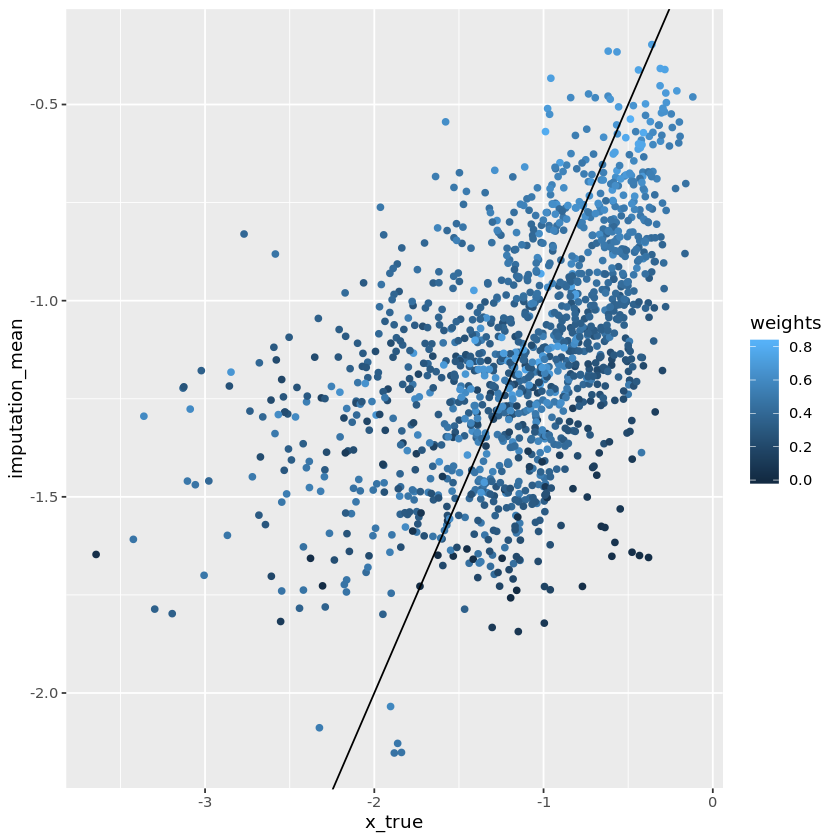

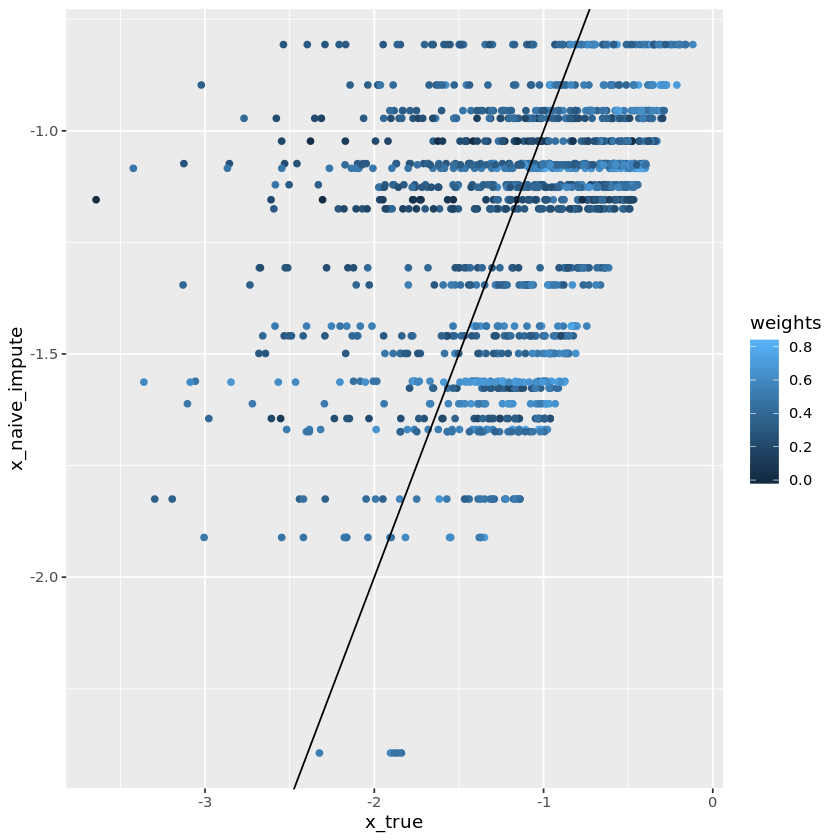

In [42]:
ggplot() + geom_point(aes(x=x_true,y=imputation_mean,color=weights)) + geom_abline(slope=1,intercept=0)

ggplot() + geom_point(aes(x=x_true,y=x_naive_impute,color=weights)) + geom_abline(slope=1,intercept=0)


### Shrinkage Amount

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



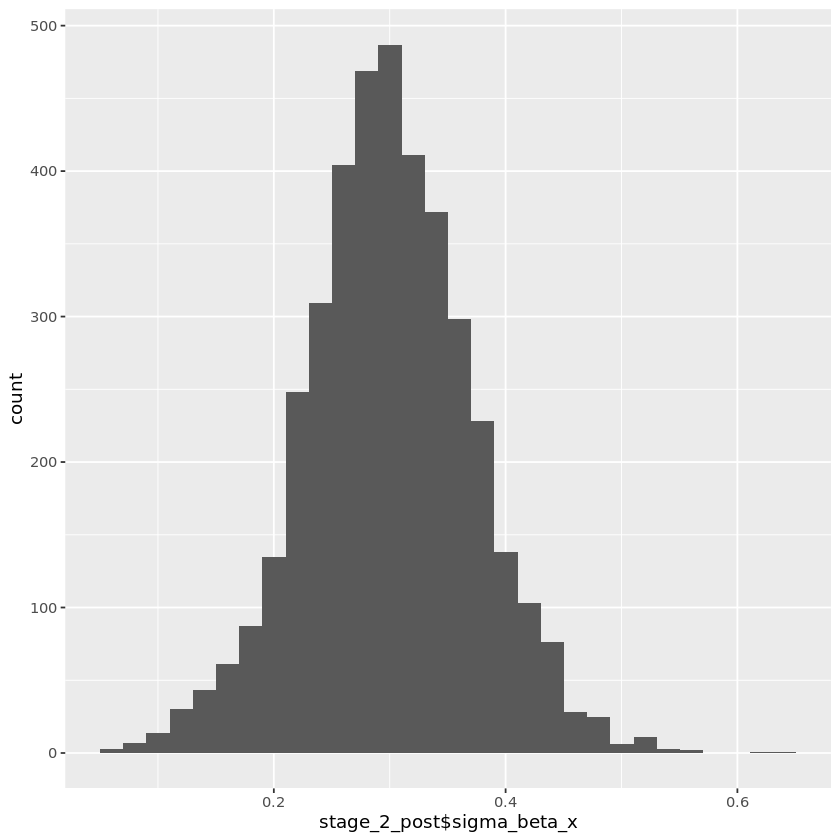

In [44]:
ggplot() + geom_histogram(aes(x=stage_2_post$sigma_beta_x))

In [46]:
######
# Compute the true effect sizes
######
#sim_data_for_truth = make_df(10000,mu_0,sigma_0,10000,mu_1,sigma_1,frac_sig=1,censor=FALSE)
#truth = sim_data_for_truth$truth
#df_eff_sim = sapply(colnames(sim_data_for_truth$df_sample)[1:27],FUN=function( x ) { apply_logistic_sim(x,df_sample) } )
#true_effs = as.numeric(df_eff_sim['Estimate',])


ERROR: Error in is.data.frame(data): object 'df_sample' not found
